# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [17]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pathlib import Path
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


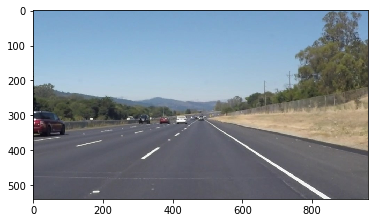

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

These are the values used for Masking the Image to focus on the Lanes section from a captured Image/Video

In [3]:
EPSILON = 0.005
LOWER_LEFT_X = 0
LOWER_LEFT_Y = 540

UPPER_LEFT_X = 450
UPPER_LEFT_Y = 320

UPPER_RIGHT_X = 490
UPPER_RIGHT_Y = 320

LOWER_RIGHT_X = 960
LOWER_RIGHT_Y = 540

LEFT_SLOPE =   -1 *(UPPER_LEFT_Y - LOWER_LEFT_Y)/ ((UPPER_LEFT_X - LOWER_LEFT_X) + EPSILON)

RIGHT_SLOPE =   -1 *(UPPER_RIGHT_Y - LOWER_RIGHT_Y)/ ((UPPER_RIGHT_X - LOWER_RIGHT_X) + EPSILON )


REGION_CENTER_X =  ((UPPER_LEFT_X + UPPER_RIGHT_X) / 2 + (LOWER_RIGHT_X + LOWER_LEFT_X) / 2 ) / 2
REGION_CENTER_Y =  ((UPPER_LEFT_Y + UPPER_RIGHT_Y) / 2 + (LOWER_RIGHT_Y + LOWER_LEFT_Y) / 2 ) / 2

print("Left Slope : {}  || Right Slope : {}".format(LEFT_SLOPE,RIGHT_SLOPE))
print("Region Center : ({},{})".format(REGION_CENTER_X,REGION_CENTER_Y))

Left Slope : 0.48888345685047946  || Right Slope : -0.4680900860647454
Region Center : (475.0,430.0)


In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Creating Array to store Slope & Intercept of every line detected by Hough
    detected_edges = np.zeros(shape=(len(lines),2))
    
    # Storing lines in different lists based on which lane they belong too
    left_lane =list()
    right_lane = list()
    
    # Storing co-oordinates in different lists based on which lane they belong too
    x_left = list()    
    y_left  = list()
    
    x_right = list()
    y_right = list()
    
    for index,line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            
            # Computing Slope & intercept of all the line detected
            detected_edges[index] = calculate_slope(line,detected_edges)
            
            # Condition check that if the points on the line are less than /on the left side of the
            # masked region, then it's part of the left lane other wise right.
            
            if (x2 < REGION_CENTER_X ) and (x1 < REGION_CENTER_X) :                 
                left_lane.append(line)
                x_left.append(x1)
                x_left.append(x2)
                y_left.append(y1)
                y_left.append(y2)
                
            elif (x2 > REGION_CENTER_X ) and (x1 > REGION_CENTER_X) :                
                right_lane.append(line)
                x_right.append(x1)
                x_right.append(x2)
                y_right.append(y1)
                y_right.append(y2)
            
    
    slope_max = detected_edges[detected_edges.argmax(axis=0)[0]]
    slope_min = detected_edges[detected_edges.argmin(axis=0)[0]]  
    print("Max Slope detected by Hough Transform: {}".format(slope_max))
    print("Min Slope by Hough Transform: {}".format(slope_min))
    
    # extrapolating straight lines from the Min & Max points
    (x1, y1), (x2, y2) = extrapolate_line(x_left,y_left)
    (x3, y3), (x4, y4) = extrapolate_line(x_right,y_right)
    
    print("Left Lane Cordinates : ",(x1, y1), (x2, y2))
    print("Right Lane Cordinates : ",(x3, y3), (x4, y4))
            
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    cv2.line(img, (x3, y3), (x4, y4), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [5]:
def calculate_slope(line,detected_edges) :
    """
    This function computes the slope & intercept from the Hough Lineand stores it
    returns  a list with the slope & intercept of the line
    """
    [[x1,y1,x2,y2]]  =  line
    dx = x2 - x1
    dy = y2 -  y1
    slope = dy/dx
    intercept = y1 - (x1 * slope)
    return [slope,intercept]
             
def extrapolate_line(x_lane,y_lane):
    """
    Extrapolates line based on the Mn & Max Cordinates of the spaecified region of interest.
    """
    
    y_min = UPPER_LEFT_Y
    y_max = LOWER_RIGHT_Y 
    coeff = np.polyfit(x_lane, y_lane, 1)
    m = coeff[0]
    b = coeff[1]
    
    x_min = int(abs((b - y_min)/m))
    x_max = int(abs((b - y_max)/m))
    
    return (x_min, y_min),(x_max, y_max)    
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Current Image : solidYellowCurve.jpg with dimensions: (540, 960, 3)
Max Slope detected by Hough Transform: [  0.66666667 -22.66666667]
Min Slope by Hough Transform: [ -0.95652174 755.26086957]
Left Lane Cordinates :  (466, 320) (165, 540)
Right Lane Cordinates :  (490, 320) (858, 540)


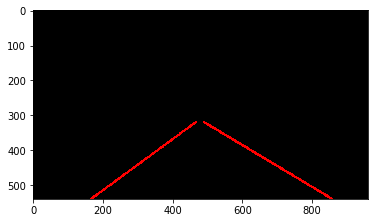

Current Image : whiteCarLaneSwitch.jpg with dimensions: (540, 960, 3)
Max Slope detected by Hough Transform: [0.625 3.   ]
Min Slope by Hough Transform: [ -0.97058824 772.41176471]
Left Lane Cordinates :  (475, 320) (173, 540)
Right Lane Cordinates :  (496, 320) (876, 540)


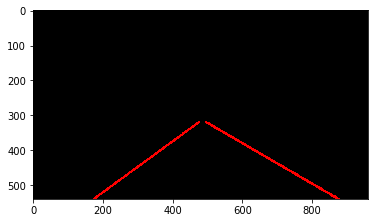

Current Image : solidYellowLeft.jpg with dimensions: (540, 960, 3)
Max Slope detected by Hough Transform: [  0.7 -38.1]
Min Slope by Hough Transform: [ -0.75 658.75]
Left Lane Cordinates :  (459, 320) (146, 540)
Right Lane Cordinates :  (501, 320) (850, 540)


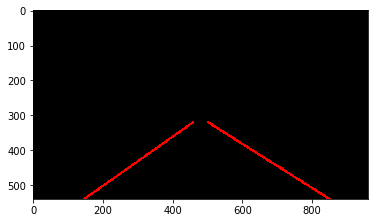

Current Image : solidWhiteRight.jpg with dimensions: (540, 960, 3)
Max Slope detected by Hough Transform: [ 0.65079365 -4.41269841]
Min Slope by Hough Transform: [ -0.85 699.7 ]
Left Lane Cordinates :  (462, 320) (146, 540)
Right Lane Cordinates :  (499, 320) (839, 540)


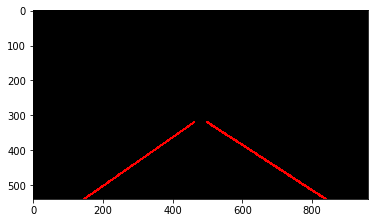

Current Image : solidWhiteCurve.jpg with dimensions: (540, 960, 3)
Max Slope detected by Hough Transform: [ 0.57817109 30.9439528 ]
Min Slope by Hough Transform: [ -0.92 748.72]
Left Lane Cordinates :  (465, 320) (183, 540)
Right Lane Cordinates :  (500, 320) (889, 540)


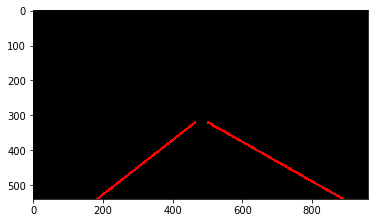

Current Image : solidYellowCurve2.jpg with dimensions: (540, 960, 3)
Max Slope detected by Hough Transform: [   0.91304348 -201.43478261]
Min Slope by Hough Transform: [ -0.8 685.4]
Left Lane Cordinates :  (465, 320) (164, 540)
Right Lane Cordinates :  (495, 320) (863, 540)


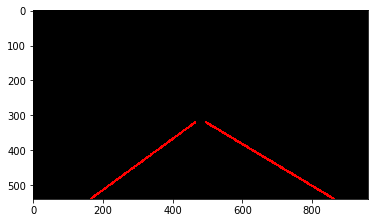

In [18]:
# TODO: Build your pipeline that will draw lane lines on the test_images
images = Path('test_images/').glob('**/*')
#images = os.listdir("test_images/")

for image_path in images :
    image = mpimg.imread(image_path)
    print("Current Image : {} with dimensions: {}".format(image_path.name,image.shape)) 
    #plt.imshow(image)
    #plt.show()
    
    # Grayscale Conversion
    img = grayscale(image)
    #plt.imshow(img)
    #plt.show()
    
    # Canny Edge Detection
    img_gaussian = gaussian_blur(img,kernel_size=3)
    img_canny = canny(img_gaussian, low_threshold =50, high_threshold=150)
    #plt.imshow(img_canny)
    #plt.show()
    
    # Region of Interest
    vertices= np.array([[(LOWER_LEFT_X,LOWER_LEFT_Y),
                         (UPPER_LEFT_X, UPPER_LEFT_Y),
                         (UPPER_RIGHT_X, UPPER_RIGHT_Y),
                         (LOWER_RIGHT_X,LOWER_RIGHT_Y)]],dtype=np.int32)
    
    img_region = region_of_interest(img_canny,vertices )    
    
    #plt.imshow(img_region)
    #plt.show()
    
    # Hough Transform
    img_hough =   hough_lines(img_region, rho = 2 , theta = np.pi /180, threshold = 10, min_line_len = 10, max_line_gap = 20)    
    plt.imshow(img_hough)
    plt.show()
    
    result = weighted_img(img_hough,image)
    #print("Final Image Shape : {} ".format(result.shape))
    #plt.imshow(result)
    #plt.show()
    #break
    
# then save them to the test_images_output directory.
    mpimg.imsave(os.path.join('test_images_output/',image_path.name), result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    
    frame = cv2.resize(image, (960,540))
    print(type(frame))
    # Grayscale Conversion
    img = grayscale(frame)
    #plt.imshow(img)
    #plt.show()

    # Canny Edge Detection
    img_gaussian = gaussian_blur(img,kernel_size=3)
    img_canny = canny(img_gaussian, low_threshold =50, high_threshold=150)
    #plt.imshow(img_canny)
    #plt.show()

    # Region of Interest
    vertices= np.array([[(LOWER_LEFT_X,LOWER_LEFT_Y),
                         (UPPER_LEFT_X, UPPER_LEFT_Y),
                         (UPPER_RIGHT_X, UPPER_RIGHT_Y),
                         (LOWER_RIGHT_X,LOWER_RIGHT_Y)]],dtype=np.int32)
    
    img_region = region_of_interest(img_canny,vertices)    

    #plt.imshow(img_region)
    #plt.show()

    # Hough Transform
    img_hough =   hough_lines(img_region, rho = 2 , theta = np.pi /180, threshold = 10, min_line_len = 10, max_line_gap = 20)    
    #plt.imshow(img_hough)
    #plt.show()

    result = weighted_img(img_hough,frame)
    #print("Final Image Shape : {} ".format(result.shape))
    #plt.imshow(result)
    #plt.show()
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68421053 -26.10526316]
Min Slope by Hough Transform: [ -0.78571429 672.92857143]
Left Lane Cordinates :  (456, 320) (157, 540)
Right Lane Cordinates :  (504, 320) (858, 540)
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  5%|▍         | 10/222 [00:00<00:02, 91.73it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68421053 -26.10526316]
Min Slope by Hough Transform: [ -0.78571429 672.92857143]
Left Lane Cordinates :  (456, 320) (157, 540)
Right Lane Cordinates :  (504, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.63636364 -11.72727273]
Min Slope by Hough Transform: [ -0.76923077 672.23076923]
Left Lane Cordinates :  (458, 320) (155, 540)
Right Lane Cordinates :  (497, 320) (864, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -33.66666667]
Min Slope by Hough Transform: [ -0.93333333 739.46666667]
Left Lane Cordinates :  (458, 320) (155, 540)
Right Lane Cordinates :  (507, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.91666667 -188.33333333]
Min Slope by Hough Transform: [ -1. 774.]
Left Lane Cordinates :  (457, 320) (155, 540)
Right Lane Cordinates :  (505, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by 

 14%|█▍        | 32/222 [00:00<00:01, 100.31it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65294118 -6.48823529]
Min Slope by Hough Transform: [ -0.71052632 652.07894737]
Left Lane Cordinates :  (462, 320) (147, 540)
Right Lane Cordinates :  (499, 320) (840, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65079365 -4.11111111]
Min Slope by Hough Transform: [ -0.85185185 688.59259259]
Left Lane Cordinates :  (462, 320) (149, 540)
Right Lane Cordinates :  (500, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75862069 -66.96551724]
Min Slope by Hough Transform: [ -0.72727273 646.90909091]
Left Lane Cordinates :  (462, 320) (148, 540)
Right Lane Cordinates :  (496, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.8 -102.6]
Min Slope by Hough Transform: [ -0.92857143 738.35714286]
Left Lane Cordinates :  (461, 320) (147, 540)
Right Lane Cordinates :  (500, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Ho

 23%|██▎       | 51/222 [00:00<00:01, 93.44it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -97.5 ]
Min Slope by Hough Transform: [ -0.95454545 735.68181818]
Left Lane Cordinates :  (455, 320) (150, 540)
Right Lane Cordinates :  (507, 320) (846, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73333333 -68.2       ]
Min Slope by Hough Transform: [ -0.77777778 670.11111111]
Left Lane Cordinates :  (455, 320) (149, 540)
Right Lane Cordinates :  (507, 320) (845, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -40.2]
Min Slope by Hough Transform: [ -0.79166667 677.16666667]
Left Lane Cordinates :  (454, 320) (149, 540)
Right Lane Cordinates :  (508, 320) (838, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73333333 -68.        ]
Min Slope by Hough Transform: [ -0.78947368 666.89473684]
Left Lane Cordinates :  (455, 320) (147, 540)
Right Lane Cordinates :  (511, 320) (837, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transf

 32%|███▏      | 70/222 [00:00<00:01, 92.77it/s]

Left Lane Cordinates :  (458, 320) (139, 540)
Right Lane Cordinates :  (497, 320) (837, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65363128 -3.8603352 ]
Min Slope by Hough Transform: [ -1.14285714 790.        ]
Left Lane Cordinates :  (459, 320) (138, 540)
Right Lane Cordinates :  (499, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.07692308 -247.        ]
Min Slope by Hough Transform: [ -0.73015873 652.6031746 ]
Left Lane Cordinates :  (458, 320) (136, 540)
Right Lane Cordinates :  (500, 320) (835, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -84.  ]
Min Slope by Hough Transform: [ -0.82608696 696.04347826]
Left Lane Cordinates :  (457, 320) (140, 540)
Right Lane Cordinates :  (499, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -37.        ]
Min Slope by Hough Transform: [ -0.8 664.6]
Left Lane Cordinates :  (458, 320) (141, 540)
Right Lane C

 40%|████      | 89/222 [00:00<00:01, 92.59it/s]

Max Slope detected by Hough Transform: [  0.67857143 -29.96428571]
Min Slope by Hough Transform: [ -0.84210526 688.36842105]
Left Lane Cordinates :  (454, 320) (125, 540)
Right Lane Cordinates :  (497, 320) (832, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.78571429 -75.71428571]
Min Slope by Hough Transform: [ -0.73913043 656.08695652]
Left Lane Cordinates :  (456, 320) (125, 540)
Right Lane Cordinates :  (495, 320) (836, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -228.]
Min Slope by Hough Transform: [ -0.77777778 664.22222222]
Left Lane Cordinates :  (454, 320) (124, 540)
Right Lane Cordinates :  (496, 320) (834, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -60.36363636]
Min Slope by Hough Transform: [ -1.08333333 807.25      ]
Left Lane Cordinates :  (455, 320) (124, 540)
Right Lane Cordinates :  (494, 320) (833, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76

 49%|████▊     | 108/222 [00:01<00:01, 90.19it/s]

Max Slope detected by Hough Transform: [  0.76315789 -66.05263158]
Min Slope by Hough Transform: [ -0.69387755 636.40816327]
Left Lane Cordinates :  (460, 320) (124, 540)
Right Lane Cordinates :  (503, 320) (816, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -59.45454545]
Min Slope by Hough Transform: [ -0.83333333 693.66666667]
Left Lane Cordinates :  (460, 320) (121, 540)
Right Lane Cordinates :  (503, 320) (826, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.83333333 -129.83333333]
Min Slope by Hough Transform: [ -0.8 681.4]
Left Lane Cordinates :  (458, 320) (126, 540)
Right Lane Cordinates :  (506, 320) (820, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.74468085 -59.12765957]
Min Slope by Hough Transform: [ -0.85714286 703.        ]
Left Lane Cordinates :  (458, 320) (125, 540)
Right Lane Cordinates :  (502, 320) (823, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0

 54%|█████▎    | 119/222 [00:01<00:01, 91.31it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7044335  -36.52216749]
Min Slope by Hough Transform: [ -0.79166667 663.375     ]
Left Lane Cordinates :  (461, 320) (141, 540)
Right Lane Cordinates :  (504, 320) (835, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.70238095 -37.01190476]
Min Slope by Hough Transform: [ -0.73333333 650.73333333]
Left Lane Cordinates :  (459, 320) (142, 540)
Right Lane Cordinates :  (504, 320) (832, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73333333 -73.93333333]
Min Slope by Hough Transform: [ -0.73684211 650.47368421]
Left Lane Cordinates :  (459, 320) (139, 540)
Right Lane Cordinates :  (508, 320) (839, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.84375 -123.15625]
Min Slope by Hough Transform: [ -0.75 656.75]
Left Lane Cordinates :  (461, 320) (135, 540)
Right Lane Cordinates :  (509, 320) (836, 540)
<class 'numpy.ndarray'>
Max Slope detected by Ho

 58%|█████▊    | 129/222 [00:01<00:01, 91.71it/s]

Max Slope detected by Hough Transform: [  0.65853659 -11.31707317]
Min Slope by Hough Transform: [ -0.78947368 678.31578947]
Left Lane Cordinates :  (464, 320) (146, 540)
Right Lane Cordinates :  (505, 320) (848, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -49.63636364]
Min Slope by Hough Transform: [ -1.26315789 887.63157895]
Left Lane Cordinates :  (464, 320) (147, 540)
Right Lane Cordinates :  (503, 320) (855, 540)
<class 'numpy.ndarray'>


 63%|██████▎   | 140/222 [00:01<00:00, 92.69it/s]

Max Slope detected by Hough Transform: [  0.71428571 -75.28571429]
Min Slope by Hough Transform: [ -0.85714286 705.57142857]
Left Lane Cordinates :  (465, 320) (151, 540)
Right Lane Cordinates :  (503, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6875 -42.875 ]
Min Slope by Hough Transform: [ -1. 781.]
Left Lane Cordinates :  (464, 320) (157, 540)
Right Lane Cordinates :  (505, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71875 -79.40625]
Min Slope by Hough Transform: [ -0.83333333 683.83333333]
Left Lane Cordinates :  (463, 320) (155, 540)
Right Lane Cordinates :  (503, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -21.        ]
Min Slope by Hough Transform: [ -1. 767.]
Left Lane Cordinates :  (462, 320) (156, 540)
Right Lane Cordinates :  (505, 320) (846, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65187713 -9.57679181]
Min Slope by 

 68%|██████▊   | 150/222 [00:01<00:00, 92.86it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.62874251 2.09580838]
Min Slope by Hough Transform: [ -0.83333333 694.5       ]
Left Lane Cordinates :  (463, 320) (158, 540)
Right Lane Cordinates :  (508, 320) (863, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.90909091 -171.63636364]
Min Slope by Hough Transform: [ -0.76315789 669.81578947]
Left Lane Cordinates :  (463, 320) (162, 540)
Right Lane Cordinates :  (509, 320) (859, 540)


 73%|███████▎  | 161/222 [00:01<00:00, 93.75it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -97.  ]
Min Slope by Hough Transform: [ -0.93333333 742.13333333]
Left Lane Cordinates :  (465, 320) (161, 540)
Right Lane Cordinates :  (507, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -53.9]
Min Slope by Hough Transform: [ -0.75 659.25]
Left Lane Cordinates :  (465, 320) (157, 540)
Right Lane Cordinates :  (515, 320) (854, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -60.9]
Min Slope by Hough Transform: [ -0.80952381 693.19047619]
Left Lane Cordinates :  (463, 320) (163, 540)
Right Lane Cordinates :  (513, 320) (866, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -51.4]
Min Slope by Hough Transform: [ -0.84848485 691.90909091]
Left Lane Cordinates :  (463, 320) (157, 540)
Right Lane Cordinates :  (512, 320) (869, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -69.4]
Min Slope by Hough Tr

 77%|███████▋  | 171/222 [00:01<00:00, 93.93it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.60869565 0.86956522]
Min Slope by Hough Transform: [ -1.1 814. ]
Left Lane Cordinates :  (464, 320) (183, 540)
Right Lane Cordinates :  (501, 320) (883, 540)
<class 'numpy.ndarray'>


 82%|████████▏ | 182/222 [00:01<00:00, 94.31it/s]

Max Slope detected by Hough Transform: [ 0.60185185 18.        ]
Min Slope by Hough Transform: [ -1. 767.]
Left Lane Cordinates :  (465, 320) (182, 540)
Right Lane Cordinates :  (502, 320) (877, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -26.66666667]
Min Slope by Hough Transform: [ -0.92307692 745.69230769]
Left Lane Cordinates :  (466, 320) (178, 540)
Right Lane Cordinates :  (501, 320) (882, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61904762 -7.47619048]
Min Slope by Hough Transform: [ -0.90322581 736.58064516]
Left Lane Cordinates :  (463, 320) (184, 540)
Right Lane Cordinates :  (499, 320) (885, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.64285714 -10.85714286]
Min Slope by Hough Transform: [ -0.84615385 706.        ]
Left Lane Cordinates :  (464, 320) (180, 540)
Right Lane Cordinates :  (504, 320) (877, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571

 91%|█████████▏| 203/222 [00:02<00:00, 94.61it/s]

Max Slope detected by Hough Transform: [  0.64285714 -20.5       ]
Min Slope by Hough Transform: [ -0.90909091 727.90909091]
Left Lane Cordinates :  (461, 320) (180, 540)
Right Lane Cordinates :  (512, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.63636364 -17.81818182]
Min Slope by Hough Transform: [ -1. 770.]
Left Lane Cordinates :  (464, 320) (185, 540)
Right Lane Cordinates :  (507, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63636364 -2.90909091]
Min Slope by Hough Transform: [ -1.33333333 920.        ]
Left Lane Cordinates :  (467, 320) (185, 540)
Right Lane Cordinates :  (505, 320) (894, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63157895 -0.26315789]
Min Slope by Hough Transform: [ -0.85454545 715.10909091]
Left Lane Cordinates :  (465, 320) (181, 540)
Right Lane Cordinates :  (504, 320) (881, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.62068966 6

100%|█████████▉| 221/222 [00:02<00:00, 94.25it/s]


<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.58333333 17.5       ]
Min Slope by Hough Transform: [ -0.85365854 715.3902439 ]
Left Lane Cordinates :  (463, 320) (184, 540)
Right Lane Cordinates :  (505, 320) (900, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57771261 31.19061584]
Min Slope by Hough Transform: [ -0.94736842 734.89473684]
Left Lane Cordinates :  (461, 320) (184, 540)
Right Lane Cordinates :  (505, 320) (893, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57777778 30.06666667]
Min Slope by Hough Transform: [ -0.91666667 733.16666667]
Left Lane Cordinates :  (464, 320) (180, 540)
Right Lane Cordinates :  (501, 320) (889, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57740586 31.0460251 ]
Min Slope by Hough Transform: [ -0.91666667 734.83333333]
Left Lane Cordinates :  (465, 320) (183, 540)
Right Lane Cordinates :  (500, 320) (888, 540)
<class 'numpy.ndarray'>
Max Slope detect

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -37. ]
Min Slope by Hough Transform: [ -1.23076923 882.46153846]
Left Lane Cordinates :  (466, 320) (118, 540)
Right Lane Cordinates :  (506, 320) (834, 540)
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  2%|▏         | 11/682 [00:00<00:06, 103.92it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -37. ]
Min Slope by Hough Transform: [ -1.23076923 882.46153846]
Left Lane Cordinates :  (466, 320) (118, 540)
Right Lane Cordinates :  (506, 320) (834, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.18181818 -443.54545455]
Min Slope by Hough Transform: [  -1.625 1061.   ]
Left Lane Cordinates :  (468, 320) (111, 540)
Right Lane Cordinates :  (506, 320) (832, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -54.72727273]
Min Slope by Hough Transform: [ -1.04761905 798.76190476]
Left Lane Cordinates :  (464, 320) (122, 540)
Right Lane Cordinates :  (507, 320) (831, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67741935 -31.03225806]
Min Slope by Hough Transform: [  -1.85714286 1166.85714286]
Left Lane Cordinates :  (468, 320) (122, 540)
Right Lane Cordinates :  (505, 320) (830, 540)
<class 'numpy.ndarray'>
Max Slope detected by Houg

  5%|▌         | 37/682 [00:00<00:05, 116.27it/s]

Left Lane Cordinates :  (459, 320) (134, 540)
Right Lane Cordinates :  (505, 320) (860, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -20.33333333]
Min Slope by Hough Transform: [  -1.71428571 1079.14285714]
Left Lane Cordinates :  (458, 320) (136, 540)
Right Lane Cordinates :  (504, 320) (861, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -41.6]
Min Slope by Hough Transform: [ -1.15 835.75]
Left Lane Cordinates :  (462, 320) (135, 540)
Right Lane Cordinates :  (507, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76 -71.04]
Min Slope by Hough Transform: [ -1.33333333 919.66666667]
Left Lane Cordinates :  (461, 320) (148, 540)
Right Lane Cordinates :  (503, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64705882 -8.11764706]
Min Slope by Hough Transform: [ -1.02941176 782.20588235]
Left Lane Cordinates :  (461, 320) (148, 540)
Right Lane Cordinates : 

  9%|▊         | 58/682 [00:00<00:05, 104.61it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -22.33333333]
Min Slope by Hough Transform: [ -1.38888889 904.5       ]
Left Lane Cordinates :  (456, 320) (146, 540)
Right Lane Cordinates :  (505, 320) (873, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -39.38461538]
Min Slope by Hough Transform: [  -1.42857143 1322.        ]
Left Lane Cordinates :  (455, 320) (151, 540)
Right Lane Cordinates :  (500, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71875 -60.9375 ]
Min Slope by Hough Transform: [ -1. 769.]
Left Lane Cordinates :  (452, 320) (150, 540)
Right Lane Cordinates :  (503, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61538462 -0.23076923]
Min Slope by Hough Transform: [ -0.83333333 660.        ]
Left Lane Cordinates :  (456, 320) (148, 540)
Right Lane Cordinates :  (503, 320) (871, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Tr

 12%|█▏        | 79/682 [00:00<00:05, 103.16it/s]

Max Slope detected by Hough Transform: [0.62790698 4.55813953]
Min Slope by Hough Transform: [ -0.875 716.625]
Left Lane Cordinates :  (454, 320) (149, 540)
Right Lane Cordinates :  (500, 320) (861, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -80.25]
Min Slope by Hough Transform: [ -1.0625 798.    ]
Left Lane Cordinates :  (455, 320) (147, 540)
Right Lane Cordinates :  (507, 320) (842, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.64864865 -10.24324324]
Min Slope by Hough Transform: [ -0.76923077 645.15384615]
Left Lane Cordinates :  (456, 320) (140, 540)
Right Lane Cordinates :  (502, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64285714 -3.35714286]
Min Slope by Hough Transform: [ -0.75 656.5 ]
Left Lane Cordinates :  (456, 320) (143, 540)
Right Lane Cordinates :  (501, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67391304 -22.76086957]
Min Slope by 

 15%|█▍        | 100/682 [00:00<00:05, 101.10it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6969697  -34.93939394]
Min Slope by Hough Transform: [ -0.70289855 644.46376812]
Left Lane Cordinates :  (457, 320) (141, 540)
Right Lane Cordinates :  (502, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -29.33333333]
Min Slope by Hough Transform: [ -1.27272727 894.        ]
Left Lane Cordinates :  (459, 320) (135, 540)
Right Lane Cordinates :  (498, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -61.75]
Min Slope by Hough Transform: [ -0.72727273 639.        ]
Left Lane Cordinates :  (462, 320) (137, 540)
Right Lane Cordinates :  (500, 320) (844, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67924528 -27.13207547]
Min Slope by Hough Transform: [ -1.16666667 852.        ]
Left Lane Cordinates :  (463, 320) (143, 540)
Right Lane Cordinates :  (495, 320) (845, 540)
<class 'numpy.ndarray'>
Max Slope detected b

 16%|█▋        | 111/682 [00:01<00:05, 100.50it/s]

Max Slope detected by Hough Transform: [  0.67391304 -21.2826087 ]
Min Slope by Hough Transform: [ -1.07142857 807.5       ]
Left Lane Cordinates :  (472, 320) (99, 540)
Right Lane Cordinates :  (499, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6969697  -32.09090909]
Min Slope by Hough Transform: [ -0.72413793 653.82758621]
Left Lane Cordinates :  (475, 320) (89, 540)
Right Lane Cordinates :  (499, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69047619 -29.47619048]
Min Slope by Hough Transform: [ -1.26315789 779.57894737]
Left Lane Cordinates :  (462, 320) (143, 540)
Right Lane Cordinates :  (499, 320) (843, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.78947368 -81.52631579]
Min Slope by Hough Transform: [ -1.25 877.75]
Left Lane Cordinates :  (465, 320) (137, 540)
Right Lane Cordinates :  (499, 320) (846, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68

 18%|█▊        | 122/682 [00:01<00:05, 101.22it/s]

Max Slope detected by Hough Transform: [  0.73333333 -64.13333333]
Min Slope by Hough Transform: [ -0.8 689.2]
Left Lane Cordinates :  (462, 320) (146, 540)
Right Lane Cordinates :  (502, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -19.66666667]
Min Slope by Hough Transform: [ -0.81818182 669.72727273]
Left Lane Cordinates :  (461, 320) (151, 540)
Right Lane Cordinates :  (503, 320) (846, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.8 -88.6]
Min Slope by Hough Transform: [ -1.18181818 774.90909091]
Left Lane Cordinates :  (462, 320) (148, 540)
Right Lane Cordinates :  (502, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.3 -548.2]
Min Slope by Hough Transform: [ -0.8 652.2]
Left Lane Cordinates :  (465, 320) (143, 540)
Right Lane Cordinates :  (503, 320) (844, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72 -45.68]
Min Slope by Hough Transform: [

 19%|█▉        | 132/682 [00:01<00:05, 100.81it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64935065 -6.15584416]
Min Slope by Hough Transform: [ -0.72560976 657.        ]
Left Lane Cordinates :  (468, 320) (153, 540)
Right Lane Cordinates :  (498, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  1. 311.]
Min Slope by Hough Transform: [ -0.83333333 671.5       ]
Left Lane Cordinates :  (466, 320) (146, 540)
Right Lane Cordinates :  (501, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69767442 -34.09302326]
Min Slope by Hough Transform: [ -0.78571429 667.71428571]
Left Lane Cordinates :  (464, 320) (151, 540)
Right Lane Cordinates :  (500, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76923077 -70.30769231]
Min Slope by Hough Transform: [ -0.72575251 658.2006689 ]
Left Lane Cordinates :  (462, 320) (156, 540)
Right Lane Cordinates :  (500, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Houg

 21%|██        | 142/682 [00:01<00:05, 100.49it/s]

Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (467, 320) (149, 540)
Right Lane Cordinates :  (499, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68627451 -25.03921569]
Min Slope by Hough Transform: [ -1.23076923 861.53846154]
Left Lane Cordinates :  (463, 320) (150, 540)
Right Lane Cordinates :  (500, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6969697  -35.72727273]
Min Slope by Hough Transform: [ -0.92105263 738.73684211]
Left Lane Cordinates :  (463, 320) (155, 540)
Right Lane Cordinates :  (500, 320) (853, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63888889 -0.58333333]
Min Slope by Hough Transform: [ -1.30769231 861.38461538]
Left Lane Cordinates :  (464, 320) (156, 540)
Right Lane Cordinates :  (499, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -65.  ]
Min Slope by Hough Transform: [ -0.76923077 678.69230769]
Left

 22%|██▏       | 152/682 [00:01<00:05, 99.98it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68181818 -32.09090909]
Min Slope by Hough Transform: [ -0.86956522 711.26086957]
Left Lane Cordinates :  (464, 320) (146, 540)
Right Lane Cordinates :  (501, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.64150943 0.69811321]
Min Slope by Hough Transform: [ -0.94444444 751.44444444]
Left Lane Cordinates :  (466, 320) (149, 540)
Right Lane Cordinates :  (498, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67164179 -21.1641791 ]
Min Slope by Hough Transform: [ -0.83333333 703.5       ]
Left Lane Cordinates :  (462, 320) (148, 540)
Right Lane Cordinates :  (500, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.8 -89.6]
Min Slope by Hough Transform: [ -0.83333333 678.83333333]
Left Lane Cordinates :  (465, 320) (150, 540)
Right Lane Cordinates :  (500, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Houg

 24%|██▍       | 162/682 [00:01<00:05, 98.80it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -69.09090909]
Min Slope by Hough Transform: [ -1.29411765 883.88235294]
Left Lane Cordinates :  (471, 320) (161, 540)
Right Lane Cordinates :  (496, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -18.        ]
Min Slope by Hough Transform: [ -0.76470588 657.64705882]
Left Lane Cordinates :  (467, 320) (156, 540)
Right Lane Cordinates :  (496, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -51.45454545]
Min Slope by Hough Transform: [ -0.76923077 662.84615385]
Left Lane Cordinates :  (470, 320) (156, 540)
Right Lane Cordinates :  (494, 320) (866, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.60714286 21.82142857]
Min Slope by Hough Transform: [ -0.8125 687.125 ]
Left Lane Cordinates :  (471, 320) (163, 540)
Right Lane Cordinates :  (494, 320) (864, 540)
<class 'numpy.ndarray'>
Max Slope detected

 26%|██▌       | 174/682 [00:01<00:05, 99.55it/s]

Max Slope detected by Hough Transform: [  0.65384615 -10.69230769]
Min Slope by Hough Transform: [ -0.76190476 666.9047619 ]
Left Lane Cordinates :  (469, 320) (162, 540)
Right Lane Cordinates :  (498, 320) (870, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68 -37.28]
Min Slope by Hough Transform: [ -1.45 865.5 ]
Left Lane Cordinates :  (471, 320) (166, 540)
Right Lane Cordinates :  (500, 320) (871, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63157895 -1.89473684]
Min Slope by Hough Transform: [ -1.25 900.5 ]
Left Lane Cordinates :  (471, 320) (169, 540)
Right Lane Cordinates :  (500, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61538462 12.69230769]
Min Slope by Hough Transform: [ -1.14285714 849.57142857]
Left Lane Cordinates :  (469, 320) (169, 540)
Right Lane Cordinates :  (499, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -24.33333333]
Min S

 27%|██▋       | 185/682 [00:01<00:04, 99.54it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61111111 14.        ]
Min Slope by Hough Transform: [ -1.2 820.4]
Left Lane Cordinates :  (468, 320) (178, 540)
Right Lane Cordinates :  (494, 320) (898, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.60869565 9.17391304]
Min Slope by Hough Transform: [ -0.82352941 689.17647059]
Left Lane Cordinates :  (467, 320) (173, 540)
Right Lane Cordinates :  (496, 320) (894, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.64705882 -18.35294118]
Min Slope by Hough Transform: [ -0.96875 767.84375]
Left Lane Cordinates :  (466, 320) (180, 540)
Right Lane Cordinates :  (494, 320) (894, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.58333333 29.08333333]
Min Slope by Hough Transform: [ -0.93333333 756.93333333]
Left Lane Cordinates :  (472, 320) (180, 540)
Right Lane Cordinates :  (495, 320) (886, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transfor

 29%|██▊       | 196/682 [00:01<00:04, 100.07it/s]

Left Lane Cordinates :  (464, 320) (187, 540)
Right Lane Cordinates :  (490, 320) (900, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 19.2]
Min Slope by Hough Transform: [ -0.86956522 713.34782609]
Left Lane Cordinates :  (466, 320) (178, 540)
Right Lane Cordinates :  (492, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.625 -0.75 ]
Min Slope by Hough Transform: [ -0.8974359  738.71794872]
Left Lane Cordinates :  (467, 320) (185, 540)
Right Lane Cordinates :  (493, 320) (885, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -52.33333333]
Min Slope by Hough Transform: [  -1.88888889 1152.66666667]
Left Lane Cordinates :  (469, 320) (183, 540)
Right Lane Cordinates :  (491, 320) (890, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.17647059 -444.        ]
Min Slope by Hough Transform: [ -1.08333333 795.5       ]
Left Lane Cordinates :  (465, 320) (182, 540)
Right Lane

 30%|███       | 207/682 [00:02<00:04, 99.84it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.76923077 -142.        ]
Min Slope by Hough Transform: [ -1.25 846.  ]
Left Lane Cordinates :  (463, 320) (170, 540)
Right Lane Cordinates :  (488, 320) (879, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -341.]
Min Slope by Hough Transform: [ -1.33333333 922.66666667]
Left Lane Cordinates :  (463, 320) (178, 540)
Right Lane Cordinates :  (489, 320) (878, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.11111111 -435.22222222]
Min Slope by Hough Transform: [ -0.8 692. ]
Left Lane Cordinates :  (469, 320) (174, 540)
Right Lane Cordinates :  (486, 320) (876, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -47.33333333]
Min Slope by Hough Transform: [ -0.82352941 678.70588235]
Left Lane Cordinates :  (464, 320) (179, 540)
Right Lane Cordinates :  (485, 320) (873, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6

 32%|███▏      | 218/682 [00:02<00:04, 100.13it/s]

Max Slope detected by Hough Transform: [  0.66666667 -15.        ]
Min Slope by Hough Transform: [ -0.79166667 668.79166667]
Left Lane Cordinates :  (465, 320) (168, 540)
Right Lane Cordinates :  (485, 320) (882, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61538462 10.76923077]
Min Slope by Hough Transform: [ -0.96 763.92]
Left Lane Cordinates :  (464, 320) (175, 540)
Right Lane Cordinates :  (489, 320) (871, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.60416667 22.04166667]
Min Slope by Hough Transform: [ -1.44444444 983.        ]
Left Lane Cordinates :  (465, 320) (174, 540)
Right Lane Cordinates :  (488, 320) (871, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 21.2]
Min Slope by Hough Transform: [  -5.5 2393. ]
Left Lane Cordinates :  (464, 320) (168, 540)
Right Lane Cordinates :  (486, 320) (877, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76666667 -84.66666667]
Min Slope

 35%|███▌      | 240/682 [00:02<00:04, 100.48it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68421053 -40.52631579]
Min Slope by Hough Transform: [ -1.0625 795.4375]
Left Lane Cordinates :  (460, 320) (158, 540)
Right Lane Cordinates :  (495, 320) (861, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -66.28571429]
Min Slope by Hough Transform: [ -0.75 666.75]
Left Lane Cordinates :  (463, 320) (163, 540)
Right Lane Cordinates :  (497, 320) (862, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61290323 17.38709677]
Min Slope by Hough Transform: [ -1.4 957. ]
Left Lane Cordinates :  (462, 320) (155, 540)
Right Lane Cordinates :  (494, 320) (866, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65384615 -13.46153846]
Min Slope by Hough Transform: [  -4.66666667 2205.66666667]
Left Lane Cordinates :  (464, 320) (157, 540)
Right Lane Cordinates :  (494, 320) (861, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  

 38%|███▊      | 262/682 [00:02<00:04, 100.25it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61538462 17.        ]
Min Slope by Hough Transform: [ -1.32142857 876.53571429]
Left Lane Cordinates :  (464, 320) (151, 540)
Right Lane Cordinates :  (491, 320) (860, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64285714 -1.        ]
Min Slope by Hough Transform: [ -0.95 754.3 ]
Left Lane Cordinates :  (466, 320) (153, 540)
Right Lane Cordinates :  (488, 320) (865, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.70588235 -43.17647059]
Min Slope by Hough Transform: [ -1.26315789 884.15789474]
Left Lane Cordinates :  (465, 320) (158, 540)
Right Lane Cordinates :  (490, 320) (853, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 31.4]
Min Slope by Hough Transform: [ -0.8 669.4]
Left Lane Cordinates :  (464, 320) (155, 540)
Right Lane Cordinates :  (488, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67857143 -

 40%|████      | 273/682 [00:02<00:04, 100.28it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -22.33333333]
Min Slope by Hough Transform: [ -0.75 656.75]
Left Lane Cordinates :  (462, 320) (150, 540)
Right Lane Cordinates :  (492, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67647059 -28.26470588]
Min Slope by Hough Transform: [ -0.78787879 678.60606061]
Left Lane Cordinates :  (463, 320) (159, 540)
Right Lane Cordinates :  (491, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.70833333 -30.29166667]
Min Slope by Hough Transform: [ -1.23529412 888.23529412]
Left Lane Cordinates :  (468, 320) (155, 540)
Right Lane Cordinates :  (492, 320) (871, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61702128 12.29787234]
Min Slope by Hough Transform: [ -0.90909091 739.36363636]
Left Lane Cordinates :  (469, 320) (160, 540)
Right Lane Cordinates :  (493, 320) (866, 540)
<class 'numpy.ndarray'>
Max Slope detected by 

 42%|████▏     | 284/682 [00:02<00:03, 100.08it/s]

Max Slope detected by Hough Transform: [ 0.56756757 44.94594595]
Min Slope by Hough Transform: [ -0.75 667.25]
Left Lane Cordinates :  (467, 320) (159, 540)
Right Lane Cordinates :  (482, 320) (877, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65625 -11.0625 ]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (467, 320) (154, 540)
Right Lane Cordinates :  (482, 320) (873, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61904762 12.95238095]
Min Slope by Hough Transform: [ -1.16666667 813.5       ]
Left Lane Cordinates :  (466, 320) (161, 540)
Right Lane Cordinates :  (486, 320) (870, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57446809 43.42553191]
Min Slope by Hough Transform: [ -1.12903226 833.58064516]
Left Lane Cordinates :  (468, 320) (150, 540)
Right Lane Cordinates :  (487, 320) (867, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.62222222 15.        ]
Min Slo

 43%|████▎     | 294/682 [00:02<00:03, 99.63it/s] 

Max Slope detected by Hough Transform: [  0.70588235 -52.35294118]
Min Slope by Hough Transform: [  -1.90909091 1186.72727273]
Left Lane Cordinates :  (482, 320) (150, 540)
Right Lane Cordinates :  (482, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.62105263 19.16842105]
Min Slope by Hough Transform: [ -1.66666667 969.66666667]
Left Lane Cordinates :  (498, 320) (120, 540)
Right Lane Cordinates :  (481, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73684211 -94.84210526]
Min Slope by Hough Transform: [ -1.33333333 930.        ]
Left Lane Cordinates :  (484, 320) (129, 540)
Right Lane Cordinates :  (481, 320) (860, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -192.]
Min Slope by Hough Transform: [  -1.66666667 1076.        ]
Left Lane Cordinates :  (464, 320) (172, 540)
Right Lane Cordinates :  (484, 320) (862, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.

 45%|████▍     | 304/682 [00:03<00:03, 98.33it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69090909 -24.27272727]
Min Slope by Hough Transform: [  -2.125 1012.   ]
Left Lane Cordinates :  (466, 320) (163, 540)
Right Lane Cordinates :  (490, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.60504202 28.99159664]
Min Slope by Hough Transform: [ -0.8 677.2]
Left Lane Cordinates :  (463, 320) (167, 540)
Right Lane Cordinates :  (490, 320) (853, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69565217 -52.        ]
Min Slope by Hough Transform: [ -0.88235294 720.58823529]
Left Lane Cordinates :  (462, 320) (169, 540)
Right Lane Cordinates :  (495, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64285714 -0.14285714]
Min Slope by Hough Transform: [ -1.46153846 958.53846154]
Left Lane Cordinates :  (469, 320) (143, 540)
Right Lane Cordinates :  (492, 320) (857, 540)
<class 'numpy.ndarray'>


 46%|████▌     | 314/682 [00:03<00:03, 98.20it/s]

Max Slope detected by Hough Transform: [   0.84210526 -119.94736842]
Min Slope by Hough Transform: [ -0.7826087  680.08695652]
Left Lane Cordinates :  (473, 320) (138, 540)
Right Lane Cordinates :  (494, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -70.72727273]
Min Slope by Hough Transform: [ -0.75451264 668.53068592]
Left Lane Cordinates :  (461, 320) (155, 540)
Right Lane Cordinates :  (497, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64583333 -4.33333333]
Min Slope by Hough Transform: [ -1.03448276 788.62068966]
Left Lane Cordinates :  (460, 320) (165, 540)
Right Lane Cordinates :  (495, 320) (860, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -20.        ]
Min Slope by Hough Transform: [ -1.08333333 814.        ]
Left Lane Cordinates :  (461, 320) (163, 540)
Right Lane Cordinates :  (495, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Tran

 48%|████▊     | 324/682 [00:03<00:03, 98.17it/s]

Max Slope detected by Hough Transform: [  0.6875 -33.0625]
Min Slope by Hough Transform: [  -3. 1673.]
Left Lane Cordinates :  (462, 320) (151, 540)
Right Lane Cordinates :  (491, 320) (864, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 25.8]
Min Slope by Hough Transform: [ -1.03703704 769.11111111]
Left Lane Cordinates :  (460, 320) (160, 540)
Right Lane Cordinates :  (493, 320) (865, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61428571 16.17142857]
Min Slope by Hough Transform: [ -0.83333333 684.66666667]
Left Lane Cordinates :  (459, 320) (156, 540)
Right Lane Cordinates :  (494, 320) (861, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68965517 -29.06896552]
Min Slope by Hough Transform: [ -0.76190476 671.33333333]
Left Lane Cordinates :  (462, 320) (154, 540)
Right Lane Cordinates :  (495, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.60215054 24.34408602]
Min Slo

 49%|████▉     | 335/682 [00:03<00:03, 98.40it/s]

Max Slope detected by Hough Transform: [  0.71428571 -45.71428571]
Min Slope by Hough Transform: [  -1.85714286 1159.57142857]
Left Lane Cordinates :  (463, 320) (158, 540)
Right Lane Cordinates :  (487, 320) (860, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -49.75]
Min Slope by Hough Transform: [ -0.8 683.8]
Left Lane Cordinates :  (463, 320) (151, 540)
Right Lane Cordinates :  (488, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.7826087  -105.04347826]
Min Slope by Hough Transform: [ -0.73033708 659.50561798]
Left Lane Cordinates :  (467, 320) (154, 540)
Right Lane Cordinates :  (488, 320) (854, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65 -2.65]
Min Slope by Hough Transform: [ -0.75 668.  ]
Left Lane Cordinates :  (462, 320) (157, 540)
Right Lane Cordinates :  (489, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72727273 -64.72727273]
Min Slope by 

 51%|█████     | 347/682 [00:03<00:03, 98.99it/s]

Max Slope detected by Hough Transform: [  0.69230769 -25.92307692]
Min Slope by Hough Transform: [ -1.36363636 940.09090909]
Left Lane Cordinates :  (475, 320) (110, 540)
Right Lane Cordinates :  (492, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -16.66666667]
Min Slope by Hough Transform: [ -1.26315789 890.68421053]
Left Lane Cordinates :  (465, 320) (142, 540)
Right Lane Cordinates :  (491, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.60869565 23.17391304]
Min Slope by Hough Transform: [  -1.77777778 1121.77777778]
Left Lane Cordinates :  (462, 320) (142, 540)
Right Lane Cordinates :  (491, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -43.28571429]
Min Slope by Hough Transform: [  -1.54545455 1015.81818182]
Left Lane Cordinates :  (462, 320) (139, 540)
Right Lane Cordinates :  (490, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Tr

 52%|█████▏    | 358/682 [00:03<00:03, 98.76it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73913043 -60.39130435]
Min Slope by Hough Transform: [  -1.53846154 1013.84615385]
Left Lane Cordinates :  (467, 320) (140, 540)
Right Lane Cordinates :  (487, 320) (863, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.8 -101.8]
Min Slope by Hough Transform: [ -1.33333333 921.33333333]
Left Lane Cordinates :  (462, 320) (151, 540)
Right Lane Cordinates :  (489, 320) (854, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -38.7]
Min Slope by Hough Transform: [  -1.57142857 1017.85714286]
Left Lane Cordinates :  (465, 320) (149, 540)
Right Lane Cordinates :  (489, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64705882 -1.94117647]
Min Slope by Hough Transform: [ -0.75 652.5 ]
Left Lane Cordinates :  (462, 320) (147, 540)
Right Lane Cordinates :  (491, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.63

 54%|█████▍    | 370/682 [00:03<00:03, 99.18it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 29. ]
Min Slope by Hough Transform: [ -0.90909091 729.27272727]
Left Lane Cordinates :  (460, 320) (150, 540)
Right Lane Cordinates :  (476, 320) (916, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.78571429 -84.78571429]
Min Slope by Hough Transform: [ -0.93333333 738.2       ]
Left Lane Cordinates :  (457, 320) (151, 540)
Right Lane Cordinates :  (471, 320) (906, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -28.57142857]
Min Slope by Hough Transform: [-1.11111111e+00  1.44777778e+03]
Left Lane Cordinates :  (455, 320) (159, 540)
Right Lane Cordinates :  (472, 320) (901, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.8125 -104.8125]
Min Slope by Hough Transform: [ -1.4 935.4]
Left Lane Cordinates :  (458, 320) (150, 540)
Right Lane Cordinates :  (486, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform:

 56%|█████▌    | 382/682 [00:03<00:03, 99.58it/s]

Left Lane Cordinates :  (458, 320) (151, 540)
Right Lane Cordinates :  (486, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.5952381  34.45238095]
Min Slope by Hough Transform: [ -1.41666667 915.        ]
Left Lane Cordinates :  (459, 320) (143, 540)
Right Lane Cordinates :  (485, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -180.]
Min Slope by Hough Transform: [ -0.77272727 660.09090909]
Left Lane Cordinates :  (458, 320) (147, 540)
Right Lane Cordinates :  (486, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.95238095 -200.57142857]
Min Slope by Hough Transform: [ -1.21428571 867.64285714]
Left Lane Cordinates :  (459, 320) (143, 540)
Right Lane Cordinates :  (488, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61016949 25.15254237]
Min Slope by Hough Transform: [ -1.33333333 805.        ]
Left Lane Cordinates :  (460, 320) (140, 540)
Ri

 58%|█████▊    | 393/682 [00:03<00:02, 99.80it/s]

Max Slope detected by Hough Transform: [  0.70588235 -45.64705882]
Min Slope by Hough Transform: [ -0.9 725.5]
Left Lane Cordinates :  (470, 320) (118, 540)
Right Lane Cordinates :  (490, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -31.15384615]
Min Slope by Hough Transform: [ -1.36363636 855.27272727]
Left Lane Cordinates :  (459, 320) (141, 540)
Right Lane Cordinates :  (488, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -32.46153846]
Min Slope by Hough Transform: [ -0.70588235 645.52941176]
Left Lane Cordinates :  (462, 320) (144, 540)
Right Lane Cordinates :  (488, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.64285714 2.64285714]
Min Slope by Hough Transform: [ -0.70642202 645.59633028]
Left Lane Cordinates :  (460, 320) (147, 540)
Right Lane Cordinates :  (489, 320) (844, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65 -2.8

 59%|█████▉    | 405/682 [00:04<00:02, 100.07it/s]


<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.64285714 7.14285714]
Min Slope by Hough Transform: [ -1. 779.]
Left Lane Cordinates :  (465, 320) (133, 540)
Right Lane Cordinates :  (488, 320) (839, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.77358491 -71.24528302]
Min Slope by Hough Transform: [ -1.04545455 794.59090909]
Left Lane Cordinates :  (464, 320) (136, 540)
Right Lane Cordinates :  (490, 320) (837, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73684211 -51.47368421]
Min Slope by Hough Transform: [  -1.66666667 1076.66666667]
Left Lane Cordinates :  (460, 320) (146, 540)
Right Lane Cordinates :  (489, 320) (837, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75609756 -65.19512195]
Min Slope by Hough Transform: [ -1.10526316 779.63157895]
Left Lane Cordinates :  (463, 320) (144, 540)
Right Lane Cordinates :  (490, 320) (835, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hou

 61%|██████    | 416/682 [00:04<00:02, 99.44it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75862069 -84.65517241]
Min Slope by Hough Transform: [ -0.75 609.25]
Left Lane Cordinates :  (468, 320) (119, 540)
Right Lane Cordinates :  (497, 320) (840, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -11.33333333]
Min Slope by Hough Transform: [ -0.73333333 643.2       ]
Left Lane Cordinates :  (476, 320) (116, 540)
Right Lane Cordinates :  (494, 320) (845, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.93333333 -153.13333333]
Min Slope by Hough Transform: [ -0.72727273 642.18181818]
Left Lane Cordinates :  (461, 320) (135, 540)
Right Lane Cordinates :  (494, 320) (845, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.775 -76.425]
Min Slope by Hough Transform: [ -0.8 653. ]
Left Lane Cordinates :  (463, 320) (136, 540)
Right Lane Cordinates :  (494, 320) (843, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.

 63%|██████▎   | 427/682 [00:04<00:02, 99.61it/s]

Max Slope detected by Hough Transform: [  0.78947368 -87.31578947]
Min Slope by Hough Transform: [ -1.25 891.25]
Left Lane Cordinates :  (467, 320) (126, 540)
Right Lane Cordinates :  (495, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.92307692 -213.61538462]
Min Slope by Hough Transform: [ -0.72727273 657.36363636]
Left Lane Cordinates :  (474, 320) (118, 540)
Right Lane Cordinates :  (495, 320) (840, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69767442 -29.88372093]
Min Slope by Hough Transform: [ -1.0625 799.25  ]
Left Lane Cordinates :  (474, 320) (133, 540)
Right Lane Cordinates :  (495, 320) (845, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67857143 -24.10714286]
Min Slope by Hough Transform: [ -0.85714286 707.        ]
Left Lane Cordinates :  (463, 320) (148, 540)
Right Lane Cordinates :  (495, 320) (842, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.772727

 64%|██████▍   | 438/682 [00:04<00:02, 99.82it/s]

Max Slope detected by Hough Transform: [  0.75 -62.5 ]
Min Slope by Hough Transform: [ -0.71428571 640.        ]
Left Lane Cordinates :  (461, 320) (138, 540)
Right Lane Cordinates :  (495, 320) (840, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71698113 -43.64150943]
Min Slope by Hough Transform: [ -0.78378378 681.40540541]
Left Lane Cordinates :  (465, 320) (142, 540)
Right Lane Cordinates :  (496, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75 -62.75]
Min Slope by Hough Transform: [ -1. 776.]
Left Lane Cordinates :  (461, 320) (133, 540)
Right Lane Cordinates :  (494, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76923077 -77.92307692]
Min Slope by Hough Transform: [ -0.95238095 754.28571429]
Left Lane Cordinates :  (463, 320) (135, 540)
Right Lane Cordinates :  (496, 320) (842, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.64814815 0.24074074]
Min Slope

 66%|██████▌   | 449/682 [00:04<00:02, 99.94it/s]

Max Slope detected by Hough Transform: [ 0.64102564 -1.94871795]
Min Slope by Hough Transform: [  -5.5 1819.5]
Left Lane Cordinates :  (461, 320) (134, 540)
Right Lane Cordinates :  (495, 320) (848, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73333333 -60.13333333]
Min Slope by Hough Transform: [  -6.5 1913.5]
Left Lane Cordinates :  (459, 320) (133, 540)
Right Lane Cordinates :  (496, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -12.66666667]
Min Slope by Hough Transform: [ -1.0952381  765.80952381]
Left Lane Cordinates :  (456, 320) (138, 540)
Right Lane Cordinates :  (499, 320) (843, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7027027 -38.       ]
Min Slope by Hough Transform: [ -0.71428571 648.71428571]
Left Lane Cordinates :  (469, 320) (125, 540)
Right Lane Cordinates :  (499, 320) (844, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -16.   

 68%|██████▊   | 461/682 [00:04<00:02, 100.22it/s]

Max Slope detected by Hough Transform: [  0.75 -88.75]
Min Slope by Hough Transform: [ -0.78787879 677.54545455]
Left Lane Cordinates :  (459, 320) (127, 540)
Right Lane Cordinates :  (499, 320) (846, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65517241 -8.27586207]
Min Slope by Hough Transform: [ -0.8 645.6]
Left Lane Cordinates :  (457, 320) (126, 540)
Right Lane Cordinates :  (500, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68181818 -22.31818182]
Min Slope by Hough Transform: [ -0.7008547  641.48717949]
Left Lane Cordinates :  (458, 320) (128, 540)
Right Lane Cordinates :  (502, 320) (843, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.82758621 -140.89655172]
Min Slope by Hough Transform: [ -1. 773.]
Left Lane Cordinates :  (459, 320) (137, 540)
Right Lane Cordinates :  (499, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -42.4]
Min Slope by Hough Tr

 69%|██████▉   | 472/682 [00:04<00:02, 100.35it/s]

Max Slope detected by Hough Transform: [ 0.66666667 -7.33333333]
Min Slope by Hough Transform: [ -0.82978723 698.27659574]
Left Lane Cordinates :  (465, 320) (144, 540)
Right Lane Cordinates :  (492, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.85714286 -123.        ]
Min Slope by Hough Transform: [ -0.67948718 640.51282051]
Left Lane Cordinates :  (464, 320) (147, 540)
Right Lane Cordinates :  (492, 320) (844, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -22.23076923]
Min Slope by Hough Transform: [ -0.94444444 739.88888889]
Left Lane Cordinates :  (467, 320) (137, 540)
Right Lane Cordinates :  (491, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65625 -11.6875 ]
Min Slope by Hough Transform: [ -1.2 841.6]
Left Lane Cordinates :  (466, 320) (139, 540)
Right Lane Cordinates :  (490, 320) (843, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65151515 

 71%|███████   | 483/682 [00:04<00:01, 100.47it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.65322581 -4.21774194]
Min Slope by Hough Transform: [ -1.45 838.6 ]
Left Lane Cordinates :  (465, 320) (135, 540)
Right Lane Cordinates :  (492, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -41.71428571]
Min Slope by Hough Transform: [ -1.16666667 768.33333333]
Left Lane Cordinates :  (472, 320) (124, 540)
Right Lane Cordinates :  (492, 320) (839, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -27.        ]
Min Slope by Hough Transform: [ -0.68852459 643.68852459]
Left Lane Cordinates :  (465, 320) (145, 540)
Right Lane Cordinates :  (490, 320) (844, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 24.6]
Min Slope by Hough Transform: [ -1. 781.]
Left Lane Cordinates :  (464, 320) (145, 540)
Right Lane Cordinates :  (490, 320) (848, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69047619 -

 74%|███████▍  | 506/682 [00:05<00:01, 100.23it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67741935 -23.29032258]
Min Slope by Hough Transform: [ -0.75609756 668.56097561]
Left Lane Cordinates :  (464, 320) (145, 540)
Right Lane Cordinates :  (501, 320) (842, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69387755 -31.28571429]
Min Slope by Hough Transform: [ -1.15789474 767.84210526]
Left Lane Cordinates :  (464, 320) (142, 540)
Right Lane Cordinates :  (497, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.68421053 -27.26315789]
Min Slope by Hough Transform: [ -1. 779.]
Left Lane Cordinates :  (466, 320) (143, 540)
Right Lane Cordinates :  (498, 320) (848, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.75757576 -77.6969697 ]
Min Slope by Hough Transform: [ -0.8 672.2]
Left Lane Cordinates :  (464, 320) (143, 540)
Right Lane Cordinates :  (498, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform:

 76%|███████▌  | 517/682 [00:05<00:01, 99.95it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -37.5]
Min Slope by Hough Transform: [ -0.94736842 737.21052632]
Left Lane Cordinates :  (462, 320) (136, 540)
Right Lane Cordinates :  (490, 320) (858, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69565217 -34.17391304]
Min Slope by Hough Transform: [ -1.22727273 851.13636364]
Left Lane Cordinates :  (465, 320) (139, 540)
Right Lane Cordinates :  (491, 320) (853, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.875 -124.125]
Min Slope by Hough Transform: [ -0.7 633.1]
Left Lane Cordinates :  (465, 320) (140, 540)
Right Lane Cordinates :  (493, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.73529412 -51.05882353]
Min Slope by Hough Transform: [ -0.93023256 734.74418605]
Left Lane Cordinates :  (464, 320) (140, 540)
Right Lane Cordinates :  (494, 320) (842, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.

 77%|███████▋  | 528/682 [00:05<00:01, 100.06it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.725 -49.9  ]
Min Slope by Hough Transform: [ -1.27272727 844.        ]
Left Lane Cordinates :  (481, 320) (122, 540)
Right Lane Cordinates :  (495, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -17.66666667]
Min Slope by Hough Transform: [ -0.82352941 707.11764706]
Left Lane Cordinates :  (465, 320) (145, 540)
Right Lane Cordinates :  (496, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.88888889 -133.        ]
Min Slope by Hough Transform: [ -0.85714286 714.42857143]
Left Lane Cordinates :  (467, 320) (138, 540)
Right Lane Cordinates :  (496, 320) (847, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69047619 -28.02380952]
Min Slope by Hough Transform: [ -0.73809524 667.21428571]
Left Lane Cordinates :  (468, 320) (141, 540)
Right Lane Cordinates :  (497, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detect

 79%|███████▉  | 539/682 [00:05<00:01, 100.01it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.8 -126.6]
Min Slope by Hough Transform: [ -1.45454545 887.72727273]
Left Lane Cordinates :  (470, 320) (148, 540)
Right Lane Cordinates :  (497, 320) (846, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -15.        ]
Min Slope by Hough Transform: [ -0.7037037  652.85185185]
Left Lane Cordinates :  (469, 320) (139, 540)
Right Lane Cordinates :  (497, 320) (843, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -47.2]
Min Slope by Hough Transform: [ -1.53846154 848.53846154]
Left Lane Cordinates :  (476, 320) (121, 540)
Right Lane Cordinates :  (497, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -24.84615385]
Min Slope by Hough Transform: [ -0.73333333 650.93333333]
Left Lane Cordinates :  (467, 320) (146, 540)
Right Lane Cordinates :  (496, 320) (851, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transf

 80%|████████  | 549/682 [00:05<00:01, 99.90it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76190476 101.57142857]
Min Slope by Hough Transform: [ -1.25 850.75]
Left Lane Cordinates :  (468, 320) (145, 540)
Right Lane Cordinates :  (501, 320) (853, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -40.5]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (466, 320) (155, 540)
Right Lane Cordinates :  (500, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.92592593 -206.51851852]
Min Slope by Hough Transform: [ -0.95652174 759.17391304]
Left Lane Cordinates :  (469, 320) (149, 540)
Right Lane Cordinates :  (501, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -57.71428571]
Min Slope by Hough Transform: [ -1.75 962.  ]
Left Lane Cordinates :  (468, 320) (149, 540)
Right Lane Cordinates :  (503, 320) (850, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64948454 -8.51546

 82%|████████▏ | 560/682 [00:05<00:01, 99.91it/s]

Max Slope detected by Hough Transform: [  0.67741935 -31.12903226]
Min Slope by Hough Transform: [ -0.77941176 682.42647059]
Left Lane Cordinates :  (468, 320) (155, 540)
Right Lane Cordinates :  (500, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.84615385 -174.23076923]
Min Slope by Hough Transform: [ -0.95833333 740.58333333]
Left Lane Cordinates :  (469, 320) (155, 540)
Right Lane Cordinates :  (502, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72222222 -55.16666667]
Min Slope by Hough Transform: [ -1.30434783 870.13043478]
Left Lane Cordinates :  (467, 320) (148, 540)
Right Lane Cordinates :  (502, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.70731707 -48.34146341]
Min Slope by Hough Transform: [ -1.8 934.8]
Left Lane Cordinates :  (469, 320) (147, 540)
Right Lane Cordinates :  (503, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.

 84%|████████▎ | 571/682 [00:05<00:01, 100.09it/s]

Max Slope detected by Hough Transform: [ 0.56410256 38.02564103]
Min Slope by Hough Transform: [ -0.73 665.02]
Left Lane Cordinates :  (469, 320) (159, 540)
Right Lane Cordinates :  (503, 320) (867, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63636364 -5.27272727]
Min Slope by Hough Transform: [ -1.26666667 834.8       ]
Left Lane Cordinates :  (468, 320) (159, 540)
Right Lane Cordinates :  (502, 320) (868, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63888889 -4.58333333]
Min Slope by Hough Transform: [ -0.76470588 670.05882353]
Left Lane Cordinates :  (463, 320) (169, 540)
Right Lane Cordinates :  (503, 320) (867, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61403509 12.0877193 ]
Min Slope by Hough Transform: [ -0.96551724 755.62068966]
Left Lane Cordinates :  (467, 320) (170, 540)
Right Lane Cordinates :  (501, 320) (879, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69444444

 85%|████████▌ | 582/682 [00:05<00:00, 100.17it/s]

Max Slope detected by Hough Transform: [ 0.63414634 -9.53658537]
Min Slope by Hough Transform: [ -1.42105263 960.89473684]
Left Lane Cordinates :  (465, 320) (175, 540)
Right Lane Cordinates :  (502, 320) (879, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65217391 -15.04347826]
Min Slope by Hough Transform: [ -0.78214286 684.47857143]
Left Lane Cordinates :  (466, 320) (172, 540)
Right Lane Cordinates :  (505, 320) (876, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.61111111 5.66666667]
Min Slope by Hough Transform: [ -1.22222222 880.22222222]
Left Lane Cordinates :  (466, 320) (167, 540)
Right Lane Cordinates :  (505, 320) (876, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65 -19.4 ]
Min Slope by Hough Transform: [ -0.875 700.875]
Left Lane Cordinates :  (464, 320) (174, 540)
Right Lane Cordinates :  (510, 320) (872, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -44.6]
Min Slo

 87%|████████▋ | 593/682 [00:05<00:00, 100.18it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.64 -8.24]
Min Slope by Hough Transform: [ -1.39130435 945.91304348]
Left Lane Cordinates :  (475, 320) (156, 540)
Right Lane Cordinates :  (501, 320) (879, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.5952381  19.83333333]
Min Slope by Hough Transform: [ -1.2 874.4]
Left Lane Cordinates :  (469, 320) (170, 540)
Right Lane Cordinates :  (498, 320) (887, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71428571 -50.28571429]
Min Slope by Hough Transform: [ -1. 792.]
Left Lane Cordinates :  (468, 320) (172, 540)
Right Lane Cordinates :  (497, 320) (881, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.67857143 -21.        ]
Min Slope by Hough Transform: [ -1. 786.]
Left Lane Cordinates :  (467, 320) (184, 540)
Right Lane Cordinates :  (494, 320) (882, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.82352941 -109.41176471]
M

 89%|████████▊ | 604/682 [00:06<00:00, 100.15it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.64285714 1.21428571]
Min Slope by Hough Transform: [  -4.25 1444.25]
Left Lane Cordinates :  (466, 320) (178, 540)
Right Lane Cordinates :  (495, 320) (876, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65 -12.55]
Min Slope by Hough Transform: [ -1.2 822. ]
Left Lane Cordinates :  (477, 320) (162, 540)
Right Lane Cordinates :  (497, 320) (876, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -32.        ]
Min Slope by Hough Transform: [ -1.05882353 809.11764706]
Left Lane Cordinates :  (481, 320) (164, 540)
Right Lane Cordinates :  (496, 320) (881, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -37.66666667]
Min Slope by Hough Transform: [ -0.86842105 728.15789474]
Left Lane Cordinates :  (464, 320) (188, 540)
Right Lane Cordinates :  (499, 320) (883, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.615384

 90%|█████████ | 615/682 [00:06<00:00, 99.88it/s] 

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.60714286 10.78571429]
Min Slope by Hough Transform: [ -1.13636364 825.59090909]
Left Lane Cordinates :  (468, 320) (192, 540)
Right Lane Cordinates :  (497, 320) (885, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -19.        ]
Min Slope by Hough Transform: [ -1.23076923 885.84615385]
Left Lane Cordinates :  (468, 320) (194, 540)
Right Lane Cordinates :  (496, 320) (887, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 17.2]
Min Slope by Hough Transform: [ -1.05882353 812.29411765]
Left Lane Cordinates :  (467, 320) (189, 540)
Right Lane Cordinates :  (498, 320) (886, 540)
<class 'numpy.ndarray'>


 92%|█████████▏| 626/682 [00:06<00:00, 99.97it/s]

Max Slope detected by Hough Transform: [ 0.64705882 -6.29411765]
Min Slope by Hough Transform: [ -1.5 997. ]
Left Lane Cordinates :  (469, 320) (188, 540)
Right Lane Cordinates :  (496, 320) (888, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63157895 -8.31578947]
Min Slope by Hough Transform: [ -0.81192661 703.63302752]
Left Lane Cordinates :  (465, 320) (193, 540)
Right Lane Cordinates :  (498, 320) (884, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 14.2]
Min Slope by Hough Transform: [ -0.91666667 749.33333333]
Left Lane Cordinates :  (464, 320) (183, 540)
Right Lane Cordinates :  (499, 320) (884, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3.25 -620.5 ]
Min Slope by Hough Transform: [  -4.33333333 1806.33333333]
Left Lane Cordinates :  (462, 320) (191, 540)
Right Lane Cordinates :  (497, 320) (885, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65384615 -10.92307692]
Min Slo

 93%|█████████▎| 636/682 [00:06<00:00, 99.87it/s]

Max Slope detected by Hough Transform: [  0.72727273 -72.45454545]
Min Slope by Hough Transform: [ -0.90909091 716.45454545]
Left Lane Cordinates :  (467, 320) (191, 540)
Right Lane Cordinates :  (493, 320) (892, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63333333 -0.86666667]
Min Slope by Hough Transform: [ -0.875 702.75 ]
Left Lane Cordinates :  (467, 320) (189, 540)
Right Lane Cordinates :  (485, 320) (905, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57575758 26.96969697]
Min Slope by Hough Transform: [  -2.375 1087.25 ]
Left Lane Cordinates :  (467, 320) (192, 540)
Right Lane Cordinates :  (494, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.70967742 -64.29032258]
Min Slope by Hough Transform: [ -0.9375 755.9375]
Left Lane Cordinates :  (468, 320) (190, 540)
Right Lane Cordinates :  (492, 320) (890, 540)
<class 'numpy.ndarray'>


 95%|█████████▍| 647/682 [00:06<00:00, 99.99it/s]

Max Slope detected by Hough Transform: [ 0.58461538 30.56923077]
Min Slope by Hough Transform: [ -0.97058824 764.82352941]
Left Lane Cordinates :  (474, 320) (172, 540)
Right Lane Cordinates :  (493, 320) (895, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65 -13.15]
Min Slope by Hough Transform: [  -4.28571429 1588.        ]
Left Lane Cordinates :  (488, 320) (164, 540)
Right Lane Cordinates :  (494, 320) (892, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57777778 34.17777778]
Min Slope by Hough Transform: [ -0.82089552 703.17910448]
Left Lane Cordinates :  (463, 320) (193, 540)
Right Lane Cordinates :  (493, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72222222 -45.11111111]
Min Slope by Hough Transform: [ -0.81372549 698.56862745]
Left Lane Cordinates :  (466, 320) (187, 540)
Right Lane Cordinates :  (493, 320) (883, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.1

 96%|█████████▋| 658/682 [00:06<00:00, 100.00it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6875 -28.25  ]
Min Slope by Hough Transform: [ -0.9 682.1]
Left Lane Cordinates :  (466, 320) (170, 540)
Right Lane Cordinates :  (500, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -38.07692308]
Min Slope by Hough Transform: [ -0.76 675.04]
Left Lane Cordinates :  (467, 320) (171, 540)
Right Lane Cordinates :  (499, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61971831 12.22535211]
Min Slope by Hough Transform: [ -1.07142857 797.28571429]
Left Lane Cordinates :  (465, 320) (164, 540)
Right Lane Cordinates :  (495, 320) (870, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6875 -50.    ]
Min Slope by Hough Transform: [ -1.3 879.9]
Left Lane Cordinates :  (468, 320) (150, 540)
Right Lane Cordinates :  (497, 320) (866, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.62962963 2.18518519]
Min

 98%|█████████▊| 669/682 [00:06<00:00, 100.08it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -19.66666667]
Min Slope by Hough Transform: [ -0.81818182 662.45454545]
Left Lane Cordinates :  (468, 320) (151, 540)
Right Lane Cordinates :  (503, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.65384615 -18.65384615]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (467, 320) (160, 540)
Right Lane Cordinates :  (504, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.62385321 6.64220183]
Min Slope by Hough Transform: [ -0.73846154 664.21538462]
Left Lane Cordinates :  (469, 320) (154, 540)
Right Lane Cordinates :  (494, 320) (870, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -56.1]
Min Slope by Hough Transform: [ -0.78571429 679.42857143]
Left Lane Cordinates :  (472, 320) (148, 540)
Right Lane Cordinates :  (495, 320) (869, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  

100%|█████████▉| 681/682 [00:06<00:00, 100.08it/s]


Max Slope detected by Hough Transform: [  0.7 -46.1]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (465, 320) (164, 540)
Right Lane Cordinates :  (494, 320) (861, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.6875 -32.6875]
Min Slope by Hough Transform: [ -0.81481481 668.88888889]
Left Lane Cordinates :  (463, 320) (158, 540)
Right Lane Cordinates :  (497, 320) (860, 540)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 31 s, sys: 1.69 s, total: 32.7 s
Wall time: 7.03 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3. -314.]
Min Slope by Hough Transform: [ -0.8 667.4]
Left Lane Cordinates :  (864, 320) (13, 540)
Right Lane Cordinates :  (357, 320) (885, 540)
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  3%|▎         | 8/251 [00:00<00:03, 70.87it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3. -314.]
Min Slope by Hough Transform: [ -0.8 667.4]
Left Lane Cordinates :  (864, 320) (13, 540)
Right Lane Cordinates :  (357, 320) (885, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    5. -2873.]
Min Slope by Hough Transform: [  -1.66666667 1100.        ]
Left Lane Cordinates :  (562, 320) (124, 540)
Right Lane Cordinates :  (134, 320) (933, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -22.        ]
Min Slope by Hough Transform: [ -1.74074074 922.81481481]
Left Lane Cordinates :  (619, 320) (109, 540)
Right Lane Cordinates :  (143, 320) (908, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3.33333333 -759.66666667]
Min Slope by Hough Transform: [  -7. 2876.]
Left Lane Cordinates :  (949, 320) (7, 540)
Right Lane Cordinates :  (207, 320) (857, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.9 -87. ]
Min Slop

 10%|▉         | 25/251 [00:00<00:02, 79.21it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.625 1.   ]
Min Slope by Hough Transform: [  -3.25 1736.  ]
Left Lane Cordinates :  (554, 320) (155, 540)
Right Lane Cordinates :  (137, 320) (854, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -3632.]
Min Slope by Hough Transform: [  -2.4 1374. ]
Left Lane Cordinates :  (616, 320) (121, 540)
Right Lane Cordinates :  (12, 320) (926, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -3645.]
Min Slope by Hough Transform: [  -2.83333333 1531.5       ]
Left Lane Cordinates :  (608, 320) (129, 540)
Right Lane Cordinates :  (230, 320) (902, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ inf -inf]
Min Slope by Hough Transform: [ -11. 4629.]
Left Lane Cordinates :  (571, 320) (151, 540)
Right Lane Cordinates :  (237, 320) (870, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    3.1 -1697.1]
Min Slope by Hough Transform: [  -1.8666

 17%|█▋        | 42/251 [00:00<00:02, 79.03it/s]

Max Slope detected by Hough Transform: [   0.85714286 -125.57142857]
Min Slope by Hough Transform: [ -10. 4239.]
Left Lane Cordinates :  (586, 320) (133, 540)
Right Lane Cordinates :  (280, 320) (866, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    2.5 -1282.5]
Min Slope by Hough Transform: [ -11.5 5710.5]
Left Lane Cordinates :  (679, 320) (101, 540)
Right Lane Cordinates :  (381, 320) (829, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -11.30769231]
Min Slope by Hough Transform: [  -3.66666667 1897.33333333]
Left Lane Cordinates :  (628, 320) (131, 540)
Right Lane Cordinates :  (291, 320) (838, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -3621.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (578, 320) (133, 540)
Right Lane Cordinates :  (333, 320) (856, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   27. -6635.]
Min Slope by Hough Transform: [  -1.6

 23%|██▎       | 57/251 [00:00<00:02, 74.18it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.57142857 -574.14285714]
Min Slope by Hough Transform: [  -1.61111111 1075.61111111]
Left Lane Cordinates :  (551, 320) (164, 540)
Right Lane Cordinates :  (445, 320) (833, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   2.18181818 -640.36363636]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (556, 320) (152, 540)
Right Lane Cordinates :  (242, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3.25 -742.5 ]
Min Slope by Hough Transform: [  -2.75 1566.75]
Left Lane Cordinates :  (531, 320) (150, 540)
Right Lane Cordinates :  (90, 320) (925, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   2.14285714 -288.42857143]
Min Slope by Hough Transform: [ -1.33333333 892.        ]
Left Lane Cordinates :  (861, 320) (75, 540)
Right Lane Cordinates :  (397, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform:

 25%|██▌       | 64/251 [00:00<00:02, 71.98it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.78947368 -31.26315789]
Min Slope by Hough Transform: [  -4.5 2392. ]
Left Lane Cordinates :  (676, 320) (104, 540)
Right Lane Cordinates :  (79, 320) (913, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.88888889 -92.22222222]
Min Slope by Hough Transform: [  -2.27272727 1244.27272727]
Left Lane Cordinates :  (549, 320) (157, 540)
Right Lane Cordinates :  (238, 320) (879, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.90909091 -527.45454545]
Min Slope by Hough Transform: [ -10. 4214.]
Left Lane Cordinates :  (551, 320) (165, 540)
Right Lane Cordinates :  (280, 320) (896, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.91666667 -109.75      ]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (561, 320) (146, 540)
Right Lane Cordinates :  (437, 320) (855, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   12

 28%|██▊       | 71/251 [00:01<00:02, 70.11it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 1.09090909 63.90909091]
Min Slope by Hough Transform: [  -3.22222222 1806.44444444]
Left Lane Cordinates :  (555, 320) (156, 540)
Right Lane Cordinates :  (173, 320) (900, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   10. -2585.]
Min Slope by Hough Transform: [ -1.57142857 985.85714286]
Left Lane Cordinates :  (582, 320) (149, 540)
Right Lane Cordinates :  (389, 320) (867, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.81818182 -43.72727273]
Min Slope by Hough Transform: [ -1.27777778 896.27777778]
Left Lane Cordinates :  (588, 320) (131, 540)
Right Lane Cordinates :  (429, 320) (887, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.11111111 -311.55555556]
Min Slope by Hough Transform: [ -1.15384615 839.92307692]
Left Lane Cordinates :  (582, 320) (138, 540)
Right Lane Cordinates :  (308, 320) (907, 540)
<class 'numpy.ndarray'>
Max Slope detected

 32%|███▏      | 80/251 [00:01<00:02, 71.35it/s]

Max Slope detected by Hough Transform: [  0.84615385 -46.76923077]
Min Slope by Hough Transform: [  -2.46666667 1446.8       ]
Left Lane Cordinates :  (541, 320) (166, 540)
Right Lane Cordinates :  (394, 320) (885, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.67857143 74.21428571]
Min Slope by Hough Transform: [  -2.86666667 1595.8       ]
Left Lane Cordinates :  (575, 320) (160, 540)
Right Lane Cordinates :  (184, 320) (950, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -143.]
Min Slope by Hough Transform: [  -2.5 1449. ]
Left Lane Cordinates :  (524, 320) (180, 540)
Right Lane Cordinates :  (175, 320) (1088, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -3636.]
Min Slope by Hough Transform: [  -5.5 2612. ]
Left Lane Cordinates :  (526, 320) (179, 540)
Right Lane Cordinates :  (250, 320) (921, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    4.66666667 -1275.66666667]
Min Slop

 35%|███▍      | 87/251 [00:01<00:02, 71.06it/s]

Max Slope detected by Hough Transform: [   2.4 -449.6]
Min Slope by Hough Transform: [  -1.4 1022.2]
Left Lane Cordinates :  (561, 320) (113, 540)
Right Lane Cordinates :  (201, 320) (938, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3.25 -758.75]
Min Slope by Hough Transform: [  -2. 1256.]
Left Lane Cordinates :  (528, 320) (128, 540)
Right Lane Cordinates :  (170, 320) (948, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    5.54545455 -1589.09090909]
Min Slope by Hough Transform: [ -21. 8458.]
Left Lane Cordinates :  (546, 320) (45, 540)
Right Lane Cordinates :  (640, 320) (1179, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   15.33333333 -4666.33333333]
Min Slope by Hough Transform: [  -2.54545455 1272.90909091]
Left Lane Cordinates :  (561, 320) (73, 540)
Right Lane Cordinates :  (334, 320) (908, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    9.2 -1937.2]
Min Slope by Hough Transform

 37%|███▋      | 94/251 [00:01<00:02, 68.97it/s]

 (308, 320) (898, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ inf -inf]
Min Slope by Hough Transform: [  -9.46153846 3339.        ]
Left Lane Cordinates :  (587, 320) (54, 540)
Right Lane Cordinates :  (366, 320) (879, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   25. -8758.]
Min Slope by Hough Transform: [ -21. 5493.]
Left Lane Cordinates :  (658, 320) (23, 540)
Right Lane Cordinates :  (388, 320) (878, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   35. -9921.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (636, 320) (21, 540)
Right Lane Cordinates :  (268, 320) (946, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   18.66666667 -6502.33333333]
Min Slope by Hough Transform: [  -7.66666667 2374.33333333]
Left Lane Cordinates :  (610, 320) (32, 540)
Right Lane Cordinates :  (347, 320) (925, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    9. -287

 40%|████      | 101/251 [00:01<00:02, 67.86it/s]

Max Slope detected by Hough Transform: [   13. -4335.]
Min Slope by Hough Transform: [ -31. 9766.]
Left Lane Cordinates :  (1096, 320) (188, 540)
Right Lane Cordinates :  (402, 320) (900, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    5. -1380.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (789, 320) (13, 540)
Right Lane Cordinates :  (357, 320) (919, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.07692308 -214.46153846]
Min Slope by Hough Transform: [  -1.33333333 1086.33333333]
Left Lane Cordinates :  (1042, 320) (48, 540)
Right Lane Cordinates :  (310, 320) (915, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    9.33333333 -1944.66666667]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (574, 320) (95, 540)
Right Lane Cordinates :  (378, 320) (926, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    2.375 -1095.375]
Min Slope by Hough Transform: [  -

 43%|████▎     | 108/251 [00:01<00:02, 67.54it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   12.5 -7778. ]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (1058, 320) (28, 540)
Right Lane Cordinates :  (1443, 320) (1712, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    6.375 -3529.125]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (780, 320) (130, 540)
Right Lane Cordinates :  (584, 320) (1180, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   16.5 -8700. ]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (1150, 320) (38, 540)
Right Lane Cordinates :  (715, 320) (1219, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -5786.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (766, 320) (103, 540)
Right Lane Cordinates :  (173, 320) (1067, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.77777778 -86.22222222]
Min Slope by Hough Transform: [  -2.25

 46%|████▌     | 115/251 [00:01<00:02, 67.06it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    16. -10815.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (720, 320) (60, 540)
Right Lane Cordinates :  (297, 320) (1073, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -296.]
Min Slope by Hough Transform: [-1.000e+00  1.221e+03]
Left Lane Cordinates :  (708, 320) (89, 540)
Right Lane Cordinates :  (12, 320) (960, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   2.11111111 -945.55555556]
Min Slope by Hough Transform: [  -1.61538462 1510.38461538]
Left Lane Cordinates :  (679, 320) (84, 540)
Right Lane Cordinates :  (4, 320) (985, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   12. -8037.]
Min Slope by Hough Transform: [  -1.54545455 1092.81818182]
Left Lane Cordinates :  (1055, 320) (28, 540)
Right Lane Cordinates :  (313, 320) (876, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.22222222 -392.1111

 49%|████▊     | 122/251 [00:01<00:01, 66.73it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    4. -2454.]
Min Slope by Hough Transform: [  -35. 25883.]
Left Lane Cordinates :  (571, 320) (163, 540)
Right Lane Cordinates :  (293, 320) (913, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -3996.]
Min Slope by Hough Transform: [  -1.63636364 1004.09090909]
Left Lane Cordinates :  (738, 320) (127, 540)
Right Lane Cordinates :  (335, 320) (874, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.42857143 -457.57142857]
Min Slope by Hough Transform: [  -1.77777778 1154.        ]
Left Lane Cordinates :  (848, 320) (97, 540)
Right Lane Cordinates :  (246, 320) (1041, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   2.5 -939.5]
Min Slope by Hough Transform: [  -1.625 1072.75 ]
Left Lane Cordinates :  (617, 320) (168, 540)
Right Lane Cordinates :  (340, 320) (878, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.375 -286.875]

 52%|█████▏    | 130/251 [00:01<00:01, 67.07it/s]

Max Slope detected by Hough Transform: [   1.33333333 -313.66666667]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (832, 320) (117, 540)
Right Lane Cordinates :  (365, 320) (849, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.5 -360.5]
Min Slope by Hough Transform: [ -0.6744186  639.09302326]
Left Lane Cordinates :  (727, 320) (101, 540)
Right Lane Cordinates :  (313, 320) (859, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.96666667 -151.73333333]
Min Slope by Hough Transform: [  -2.8 1541.6]
Left Lane Cordinates :  (539, 320) (116, 540)
Right Lane Cordinates :  (263, 320) (869, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.94117647 -106.47058824]
Min Slope by Hough Transform: [ -1.77777778 922.11111111]
Left Lane Cordinates :  (609, 320) (111, 540)
Right Lane Cordinates :  (325, 320) (862, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.76470588 -528.5882352

 55%|█████▍    | 138/251 [00:02<00:01, 66.65it/s]

Max Slope detected by Hough Transform: [    30. -12630.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (544, 320) (138, 540)
Right Lane Cordinates :  (379, 320) (878, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.89473684 -30.52631579]
Min Slope by Hough Transform: [ -1.1 902.6]
Left Lane Cordinates :  (535, 320) (134, 540)
Right Lane Cordinates :  (398, 320) (848, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.38461538 -250.30769231]
Min Slope by Hough Transform: [  -27. 12077.]
Left Lane Cordinates :  (566, 320) (137, 540)
Right Lane Cordinates :  (377, 320) (841, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.76923077 -38.23076923]
Min Slope by Hough Transform: [ -0.78571429 688.07142857]
Left Lane Cordinates :  (567, 320) (153, 540)
Right Lane Cordinates :  (360, 320) (894, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.85714286 -47.28571429]
Min Slope by Ho

 58%|█████▊    | 146/251 [00:02<00:01, 66.81it/s]

Max Slope detected by Hough Transform: [    4. -1640.]
Min Slope by Hough Transform: [  -2.44444444 1622.55555556]
Left Lane Cordinates :  (685, 320) (119, 540)
Right Lane Cordinates :  (325, 320) (952, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    7. -2785.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (599, 320) (131, 540)
Right Lane Cordinates :  (265, 320) (1010, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    7. -2608.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (650, 320) (85, 540)
Right Lane Cordinates :  (314, 320) (974, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   13. -7505.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (768, 320) (41, 540)
Right Lane Cordinates :  (303, 320) (962, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ inf -inf]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (693, 320)

 61%|██████    | 153/251 [00:02<00:01, 65.92it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   18. -6273.]
Min Slope by Hough Transform: [  -8. 2971.]
Left Lane Cordinates :  (564, 320) (70, 540)
Right Lane Cordinates :  (256, 320) (915, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    33. -11042.]
Min Slope by Hough Transform: [ -10. 4298.]
Left Lane Cordinates :  (694, 320) (9, 540)
Right Lane Cordinates :  (315, 320) (884, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ inf -inf]
Min Slope by Hough Transform: [  -6.33333333 3160.        ]
Left Lane Cordinates :  (722, 320) (16, 540)
Right Lane Cordinates :  (17, 320) (1004, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 1.25 -8.5 ]
Min Slope by Hough Transform: [ -1.11764706 755.05882353]
Left Lane Cordinates :  (639, 320) (58, 540)
Right Lane Cordinates :  (317, 320) (920, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 1.35294118 -6.52941176]
Min Slope by Hough Transfo

 64%|██████▍   | 161/251 [00:02<00:01, 66.36it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.69230769 -36.76923077]
Min Slope by Hough Transform: [ -1.71428571 844.57142857]
Left Lane Cordinates :  (577, 320) (74, 540)
Right Lane Cordinates :  (223, 320) (926, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.78787879 -94.03030303]
Min Slope by Hough Transform: [-1.375000e+00  1.759125e+03]
Left Lane Cordinates :  (586, 320) (56, 540)
Right Lane Cordinates :  (252, 320) (920, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7826087  -87.17391304]
Min Slope by Hough Transform: [ -1.04545455 721.95454545]
Left Lane Cordinates :  (492, 320) (108, 540)
Right Lane Cordinates :  (418, 320) (926, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.71875 -47.5    ]
Min Slope by Hough Transform: [ -1.33333333 956.66666667]
Left Lane Cordinates :  (504, 320) (91, 540)
Right Lane Cordinates :  (435, 320) (921, 540)
<class 'numpy.ndarray'>
Max Slope detec

 67%|██████▋   | 169/251 [00:02<00:01, 66.88it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   11. -3632.]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (654, 320) (90, 540)
Right Lane Cordinates :  (303, 320) (901, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1. -201.]
Min Slope by Hough Transform: [ -0.84615385 758.07692308]
Left Lane Cordinates :  (1192, 320) (148, 540)
Right Lane Cordinates :  (390, 320) (881, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.22222222 -321.33333333]
Min Slope by Hough Transform: [ -1.09090909 825.27272727]
Left Lane Cordinates :  (833, 320) (68, 540)
Right Lane Cordinates :  (404, 320) (897, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.8 -88.8]
Min Slope by Hough Transform: [-1.85714286e+00  2.20200000e+03]
Left Lane Cordinates :  (898, 320) (55, 540)
Right Lane Cordinates :  (439, 320) (892, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  1.27272727 -49.4

 71%|███████   | 178/251 [00:02<00:01, 67.62it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.23076923 -198.46153846]
Min Slope by Hough Transform: [ -1.04761905 815.38095238]
Left Lane Cordinates :  (611, 320) (142, 540)
Right Lane Cordinates :  (299, 320) (920, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.7 -53.1]
Min Slope by Hough Transform: [ -1.2 857.6]
Left Lane Cordinates :  (696, 320) (86, 540)
Right Lane Cordinates :  (75, 320) (978, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.82352941 -165.82352941]
Min Slope by Hough Transform: [ -1. 799.]
Left Lane Cordinates :  (980, 320) (1, 540)
Right Lane Cordinates :  (51, 320) (1024, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   32. -9255.]
Min Slope by Hough Transform: [-2.2000e+00  2.5632e+03]
Left Lane Cordinates :  (671, 320) (96, 540)
Right Lane Cordinates :  (169, 320) (957, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  1.42105263 134.26315789]


 74%|███████▍  | 186/251 [00:02<00:00, 67.87it/s]

Max Slope detected by Hough Transform: [   3.14285714 -696.57142857]
Min Slope by Hough Transform: [ -0.75 703.25]
Left Lane Cordinates :  (676, 320) (105, 540)
Right Lane Cordinates :  (62, 320) (950, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.53846154 -557.07692308]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (920, 320) (61, 540)
Right Lane Cordinates :  (83, 320) (944, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   18. -6186.]
Min Slope by Hough Transform: [  -9. 3024.]
Left Lane Cordinates :  (592, 320) (136, 540)
Right Lane Cordinates :  (258, 320) (943, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    6.5 -5468. ]
Min Slope by Hough Transform: [ -1.21428571 854.        ]
Left Lane Cordinates :  (647, 320) (120, 540)
Right Lane Cordinates :  (307, 320) (929, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   3.83333333 -768.5       ]
Min Slope by Hough Transfo

 78%|███████▊  | 195/251 [00:02<00:00, 68.36it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.72 -55.68]
Min Slope by Hough Transform: [ -1.06896552 820.        ]
Left Lane Cordinates :  (635, 320) (132, 540)
Right Lane Cordinates :  (102, 320) (1062, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    7.66666667 -2363.33333333]
Min Slope by Hough Transform: [ -1.15384615 797.15384615]
Left Lane Cordinates :  (558, 320) (167, 540)
Right Lane Cordinates :  (286, 320) (884, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    4.4 -1134.2]
Min Slope by Hough Transform: [  -7. 3103.]
Left Lane Cordinates :  (586, 320) (146, 540)
Right Lane Cordinates :  (269, 320) (932, 540)
<class 'numpy.ndarray'>


 81%|████████  | 203/251 [00:02<00:00, 67.99it/s]

Max Slope detected by Hough Transform: [ 0.63157895 -3.        ]
Min Slope by Hough Transform: [ -1.18518519 854.62962963]
Left Lane Cordinates :  (570, 320) (146, 540)
Right Lane Cordinates :  (272, 320) (969, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 1.04761905 81.9047619 ]
Min Slope by Hough Transform: [  -3.66666667 1548.66666667]
Left Lane Cordinates :  (988, 320) (56, 540)
Right Lane Cordinates :  (147, 320) (959, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -25.66666667]
Min Slope by Hough Transform: [ -1.92307692 968.76923077]
Left Lane Cordinates :  (696, 320) (115, 540)
Right Lane Cordinates :  (265, 320) (950, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.4375 -657.8125]
Min Slope by Hough Transform: [  -3.5 1576. ]
Left Lane Cordinates :  (615, 320) (136, 540)
Right Lane Cordinates :  (47, 320) (1040, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 

 84%|████████▍ | 211/251 [00:03<00:00, 68.30it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.61904762 5.23809524]
Min Slope by Hough Transform: [ -0.9 713.8]
Left Lane Cordinates :  (651, 320) (155, 540)
Right Lane Cordinates :  (215, 320) (932, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   2.2 -342.8]
Min Slope by Hough Transform: [  -1.71428571 1156.14285714]
Left Lane Cordinates :  (819, 320) (90, 540)
Right Lane Cordinates :  (367, 320) (913, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -21.33333333]
Min Slope by Hough Transform: [  -3.625 1581.25 ]
Left Lane Cordinates :  (610, 320) (157, 540)
Right Lane Cordinates :  (192, 320) (970, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63636364 -4.36363636]
Min Slope by Hough Transform: [  -4.33333333 1740.66666667]
Left Lane Cordinates :  (638, 320) (160, 540)
Right Lane Cordinates :  (394, 320) (897, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   0.

 88%|████████▊ | 220/251 [00:03<00:00, 68.89it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [    6. -1769.]
Min Slope by Hough Transform: [  -2.53846154 1242.07692308]
Left Lane Cordinates :  (561, 320) (167, 540)
Right Lane Cordinates :  (172, 320) (950, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.6 14. ]
Min Slope by Hough Transform: [  -5.66666667 2605.66666667]
Left Lane Cordinates :  (684, 320) (140, 540)
Right Lane Cordinates :  (1, 320) (920, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.70833333 21.29166667]
Min Slope by Hough Transform: [ -1. 805.]
Left Lane Cordinates :  (580, 320) (162, 540)
Right Lane Cordinates :  (99, 320) (852, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.22222222 -264.        ]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (650, 320) (143, 540)
Right Lane Cordinates :  (177, 320) (891, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 1.13333333 46.26666667]
Mi

 91%|█████████ | 228/251 [00:03<00:00, 69.22it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.62068966 -1.10344828]
Min Slope by Hough Transform: [-3.33333333e+00  3.38933333e+03]
Left Lane Cordinates :  (700, 320) (133, 540)
Right Lane Cordinates :  (96, 320) (974, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.60869565 9.69565217]
Min Slope by Hough Transform: [ -0.81428571 713.37142857]
Left Lane Cordinates :  (602, 320) (157, 540)
Right Lane Cordinates :  (165, 320) (934, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61538462 13.84615385]
Min Slope by Hough Transform: [ -1.44444444 963.44444444]
Left Lane Cordinates :  (701, 320) (119, 540)
Right Lane Cordinates :  (368, 320) (893, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  1. 138.]
Min Slope by Hough Transform: [ -17. 6888.]
Left Lane Cordinates :  (652, 320) (162, 540)
Right Lane Cordinates :  (19, 320) (949, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0

 94%|█████████▍| 236/251 [00:03<00:00, 69.51it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.84210526 -38.31578947]
Min Slope by Hough Transform: [  -6. 2711.]
Left Lane Cordinates :  (667, 320) (129, 540)
Right Lane Cordinates :  (19, 320) (954, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.61538462 10.92307692]
Min Slope by Hough Transform: [ -1.33333333 839.        ]
Left Lane Cordinates :  (667, 320) (111, 540)
Right Lane Cordinates :  (153, 320) (1112, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.88888889 -59.55555556]
Min Slope by Hough Transform: [  -1.75 1130.5 ]
Left Lane Cordinates :  (545, 320) (165, 540)
Right Lane Cordinates :  (216, 320) (1022, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.74074074 -95.33333333]
Min Slope by Hough Transform: [ -1. 800.]
Left Lane Cordinates :  (565, 320) (159, 540)
Right Lane Cordinates :  (1055, 320) (1306, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.666

 97%|█████████▋| 244/251 [00:03<00:00, 69.77it/s]

<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.57142857 38.14285714]
Min Slope by Hough Transform: [ -1.1 842.5]
Left Lane Cordinates :  (667, 320) (149, 540)
Right Lane Cordinates :  (413, 320) (870, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.1 -382.7]
Min Slope by Hough Transform: [  -1.8 1015.6]
Left Lane Cordinates :  (661, 320) (129, 540)
Right Lane Cordinates :  (155, 320) (943, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [0.75 3.75]
Min Slope by Hough Transform: [  -5.5 5291. ]
Left Lane Cordinates :  (588, 320) (161, 540)
Right Lane Cordinates :  (83, 320) (936, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.58823529 29.05882353]
Min Slope by Hough Transform: [  -2.22222222 1097.55555556]
Left Lane Cordinates :  (688, 320) (75, 540)
Right Lane Cordinates :  (393, 320) (904, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  1.625 -93.5  ]
Min Slope by Hough Tr

100%|██████████| 251/251 [00:03<00:00, 70.14it/s]


Max Slope detected by Hough Transform: [ inf -inf]
Min Slope by Hough Transform: [ -2.11111111 877.11111111]
Left Lane Cordinates :  (977, 320) (48, 540)
Right Lane Cordinates :  (141, 320) (983, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [  0.66666667 -20.66666667]
Min Slope by Hough Transform: [-2.83333333e+00  2.98700000e+03]
Left Lane Cordinates :  (707, 320) (109, 540)
Right Lane Cordinates :  (73, 320) (1005, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [ 0.63414634 -1.75609756]
Min Slope by Hough Transform: [-inf  inf]
Left Lane Cordinates :  (601, 320) (155, 540)
Right Lane Cordinates :  (200, 320) (936, 540)
<class 'numpy.ndarray'>
Max Slope detected by Hough Transform: [   1.15384615 -351.46153846]
Min Slope by Hough Transform: [ -17. 6869.]
Left Lane Cordinates :  (762, 320) (100, 540)
Right Lane Cordinates :  (1267, 320) (1424, 540)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))